In [0]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/brain/Brain_Tumor_Classification')

In [0]:
image_size = [224,224]
data_path = 'Data'

In [0]:
vgg = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)
# vgg = VGG16(input_shape= image_size+[3],include_top=False)

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
incp3 = InceptionV3(input_shape= image_size+[3],weights='imagenet',include_top=False) 

87916544/87910968 [==============================] - 4s 0us/step


In [20]:
vgg.output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [0]:
x = vgg.output
x = GlobalAveragePooling2D()(x)

In [0]:
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)

In [0]:
preds = Dense(2,activation='softmax')(x)
#Prediction layer with 2 Neurons because we have to classify between 2 Categories 
#add *Softmax* Activation Function which is for Probability Distribution

In [0]:
model = Model(inputs = vgg.input,outputs=preds)
# model2 = Model(inputs = vgg_wt.input,outputs=preds)

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# for layer in vgg.layers[:20]:
#     layer.trainable=False
# for layer in vgg.layers[20:]:
#     layer.trainable = True

In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2) #included in our dependencies
#a Keras ImageDataGenerator  object that is used to apply data augmentation, randomly translating, rotating, resizing, etc. images on the fly
#Performing data augmentation is a form of regularization, enabling our model to generalize better

train_generator=train_datagen.flow_from_directory('Data/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

test_generator=train_datagen.flow_from_directory('Data/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [29]:
type(train_datagen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [0]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
print(train_generator.n)
print(train_generator.batch_size)
print(253//32)

203
32
7


In [32]:
from keras.callbacks import History, ModelCheckpoint
filepath = 'Model/Model-ep{epoch:03d}-loss{loss:3f}-acc{acc:3f}.h5'
early_stop = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
callbacks_list = [early_stop]


step_size_train=train_generator.n//train_generator.batch_size
# r = model.fit_generator(generator=train_generator,
#                    steps_per_epoch=step_size_train,
#                    epochs=5, callbacks=callbacks_list)

history = model.fit_generator(train_generator, callbacks=callbacks_list, epochs=5, 
                              steps_per_epoch=step_size_train, validation_data=test_generator,
                              validation_steps=50//train_generator.batch_size, verbose=1, 
                              use_multiprocessing=True, workers=8, max_queue_size=10, shuffle=True)

Epoch 1/5
1/6 [====>.........................] - ETA: 2:16 - loss: 0.3680 - acc: 0.8438
Epoch 00001: saving model to Model/Model-ep001-loss3.217210-acc0.590643.h5
6/6 [==============================] - 107s 18s/step - loss: 4.0617 - acc: 0.5906 - val_loss: 0.3680 - val_acc: 0.8438
Epoch 2/5
1/6 [====>.........................] - ETA: 1:03 - loss: 0.3451 - acc: 0.9062
Epoch 00002: saving model to Model/Model-ep002-loss0.643324-acc0.649123.h5
6/6 [==============================] - 75s 12s/step - loss: 0.6483 - acc: 0.6491 - val_loss: 0.3451 - val_acc: 0.9062
Epoch 3/5
1/6 [====>.........................] - ETA: 1:02 - loss: 0.3876 - acc: 0.8438
Epoch 00003: saving model to Model/Model-ep003-loss0.358220-acc0.848958.h5
6/6 [==============================] - 81s 13s/step - loss: 0.3582 - acc: 0.8490 - val_loss: 0.3876 - val_acc: 0.8438
Epoch 4/5
1/6 [====>.........................] - ETA: 1:03 - loss: 0.3573 - acc: 0.9375
Epoch 00004: saving model to Model/Model-ep004-loss0.252478-acc0.883

In [0]:
# Overfitting if: training loss << validation loss
# Underfitting if: training loss >> validation loss
# Just right if training loss ~ validation loss

# # plot the loss
# plt.plot(history.history['loss'], label='train loss')
# # plt.plot(r.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# plt.plot(history.history['acc'], label='train accuracy')
# # plt.savefig('LossVal_loss')
# plt.legend()
# plt.show()
# # plot the loss
# plt.plot(history.history['val_loss'], label='test loss')
# # plt.plot(r.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# plt.plot(history.history['val_acc'], label='test accuracy')
# # plt.savefig('LossVal_loss')
# plt.legend()
# plt.show()

<Figure size 432x288 with 0 Axes>

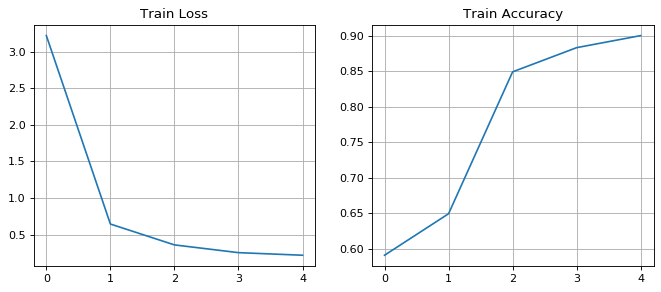

In [53]:
plt.figure()
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
# Train Loss
plt.subplot(121)
plt.plot(history.history['loss'], label='train loss')
# plt.yscale('linear')
plt.title('Train Loss')
plt.grid(True)


# Train Accuracy
plt.subplot(122)
plt.plot(history.history['acc'], label='train acc')
plt.title('Train Accuracy')
plt.grid(True)

plt.show()

<Figure size 432x288 with 0 Axes>

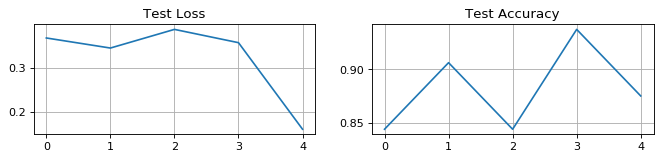

In [54]:
plt.figure()
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
# Test Loss
plt.subplot(223)
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Test Loss')
plt.grid(True)

# Test accuracy
plt.subplot(224)
plt.plot(history.history['val_acc'], label='train acc')
plt.title('Test Accuracy')
plt.grid(True)
plt.show()

In [0]:
from tensorflow.keras.models import load_model

In [0]:
# model.save('test2_brain_tumor.h5')

In [36]:
history.history

{'acc': [0.5906433, 0.64912283, 0.8489583, 0.88304096, 0.9],
 'loss': [3.2172100334836724,
  0.6433244504426655,
  0.35822027921676636,
  0.25247758661794384,
  0.21701092685262363],
 'val_acc': [0.84375, 0.90625, 0.84375, 0.9375, 0.875],
 'val_loss': [0.3680068850517273,
  0.34505268931388855,
  0.38759613037109375,
  0.35730454325675964,
  0.15983900427818298]}